In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split, learning_curve, validation_curve, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from xgboost import XGBClassifier
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler

In [28]:
def get_accuracy(model):

    print('-' * 80)
    print(f'\nMODEL: {model}\n')

    # Get sklearn accuracy score for given model; e.g., https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB.score
    y_train_pred=model.predict(X_train)
    train_score = accuracy_score(y_train, y_train_pred)

    y_test_pred=model.predict(X_test)
    test_score = accuracy_score(y_test, y_test_pred)

    print(f'[*] Train Score: {str(train_score)}')
    print(f'[*] Test Score: {str(test_score)}')

    print('\n[*] Test Classification Report: \n', metrics.classification_report(y_test, y_test_pred))

    print('[*] Confusion Matrix on Test data')
    '''
    metrics.ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=list(range(2)), # length of unique values for label
    )
    '''
    cm = metrics.confusion_matrix(y_test, y_test_pred, labels=model.classes_)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()

    print(f'[*] Test Accuracy: {str(round(test_score, 5) * 100)}%')
    print('-' * 80 + '\n')

def select_optimal_model_parameters(default_model, gridsearch_model):
    """ Calculates accuracy for the default and Gridsearch nominated parameters and appends the model with the highest accuracy to the model evaluation list """
    # save for selection comparison against GridSearch nomination
    y_pred = default_model.predict(X_test)
    default_model_acc = metrics.accuracy_score(y_test, y_pred) *100

    y_pred = gridsearch_model.predict(X_test)
    gridsearch_model_acc = metrics.accuracy_score(y_test, y_pred) *100

    # Compare the default and GridSearch paramaters for highest accuracy model to append to evaluation list
    if default_model_acc >= gridsearch_model_acc:
        print('Default parameter model selected')
        models.append(default_model)
    else:
        print('Gridsearch parameter model selected')
        models.append(gridsearch_model)

In [29]:

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(figsize=(10, 6))
        
    train_sizes, train_scores, test_scores = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    
    # Extract mean and standard deviation from the learning curve results
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)


    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
    axes.plot(train_sizes, train_scores_mean, label="Training score")
    axes.plot(train_sizes, test_scores_mean, label="Validation score")
    axes.set_title(title)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")
    axes.legend(loc="best")
    if ylim is not None:
        axes.set_ylim(*ylim)

def plot_validation_curve(estimator, X, y, param_name, param_range, cv=5, scoring="accuracy"):
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=-1
    )


    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)


    plt.figure(figsize=(10, 6))
    plt.title("Validation Curve")
    plt.xlabel(param_name)
    plt.ylabel(f"Score ({scoring})")
    plt.plot(param_range, train_scores_mean, label="Training score")
    plt.plot(param_range, test_scores_mean, label="Validation score")
    plt.legend(loc="best")
    plt.show()

In [30]:
models = []
# Load the dataset
file_path = "jobs_in_data.csv"
df = pd.read_csv(file_path)

# Convert 'salary_in_usd' to categories
df['salary_usd_group'] = pd.cut(
    df['salary_in_usd'],
    bins=[0, 50_000, 100_000, 200_000, 300_000, 400_000, 500_000],
    labels=['0-50K', '50k-100k', '100k-200k', '200k-300k', '300k-400k', '400k-500k']
)

# Encode categorical variables
le = LabelEncoder()
for column in df.select_dtypes(include=['object']).columns:
    df[column] = le.fit_transform(df[column])

# Separate features and target
X = df.drop(['salary', 'salary_in_usd'], axis=1)
y = df['salary_usd_group']

y=le.fit_transform(y)

# Identify numerical and categorical features
numerical_features = X.select_dtypes(include=['number']).columns.tolist()
categorical_features = X.select_dtypes(exclude=['number']).columns.tolist()

# Creating transformers for preprocessing
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Use ColumnTransformer to apply transformers to specific feature columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ],
    remainder='passthrough'
)

# Use RandomOverSampler to oversample minority classes
oversampler = RandomOverSampler(random_state=42)
X, y = oversampler.fit_resample(X, y)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       355
           1       1.00      1.00      1.00       390
           2       1.00      1.00      1.00       399
           3       1.00      1.00      1.00       436
           4       1.00      1.00      1.00       399
           5       1.00      1.00      1.00       399

    accuracy                           1.00      2378
   macro avg       1.00      1.00      1.00      2378
weighted avg       1.00      1.00      1.00      2378

Confusion Matrix:
 [[355   0   0   0   0   0]
 [  0 390   0   0   0   0]
 [  0   0 399   0   0   0]
 [  0   0   0 436   0   0]
 [  0   0   0   0 399   0]
 [  0   0   0   0   0 399]]


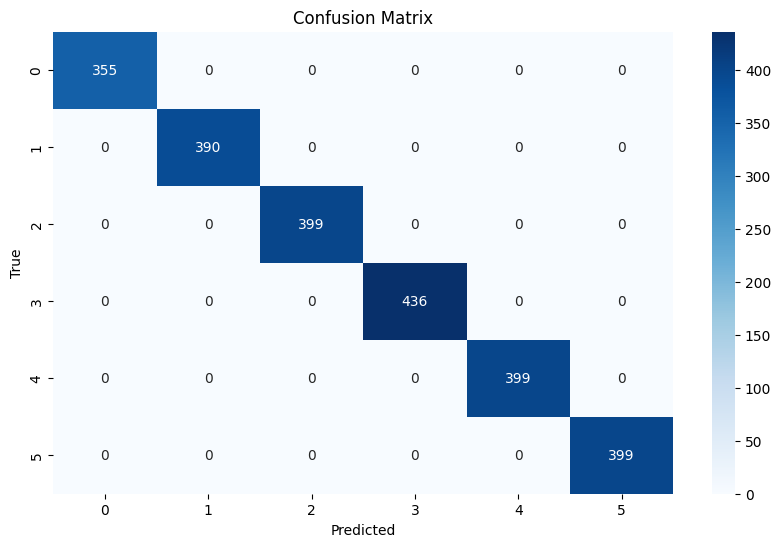

Total time taken : 0.06 seconds


In [22]:
import time
start_time = time.time()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=13)


params = {'objective':'multi:softmax','num_class':len(np.unique(y)),'eval_metric':'logloss','max_depth':3,'min_child_weight':1,'subsample':0.8,'colsample_bytree':0.8}
# clf = XGBClassifier(objective='multi:softmax')
dtrain = xgb.DMatrix(X_train,label=y_train,enable_categorical=True)
dtest = xgb.DMatrix(X_test,label=y_test,enable_categorical=True)
model = xgb.train(params,dtrain)
y_pred = model.predict(dtest)
y_pred = (y_pred).astype(int)


end_time = time.time()

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Visualization (consider using different plots for classification)
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


total_time = end_time-start_time
print(f"Total time taken : {total_time:.2f} seconds")

C:\Users\Abhishek.Agarwal\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:542: FitFailedWarning: 
21 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Abhishek.Agarwal\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Python311\Lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Python311\Lib\site-packages\xgboost\sklearn.py", line 1471, in fit
    raise ValueError(
ValueError: Invalid c

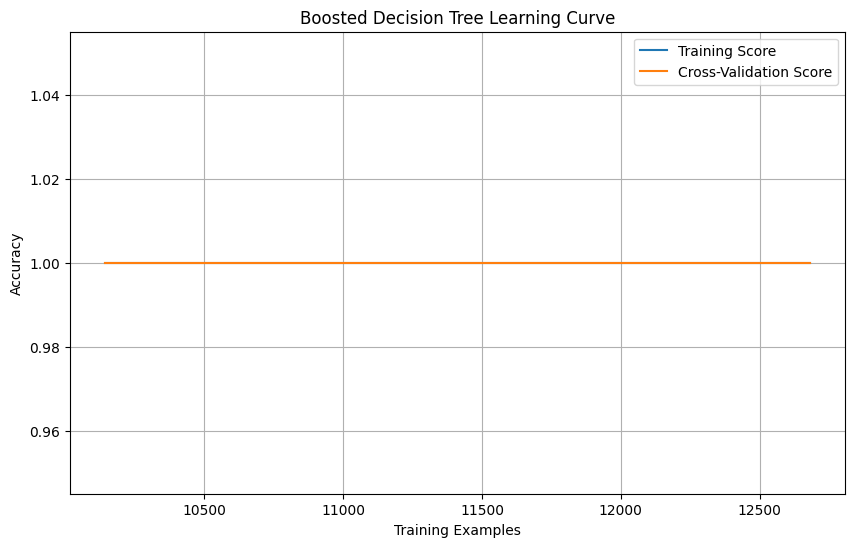

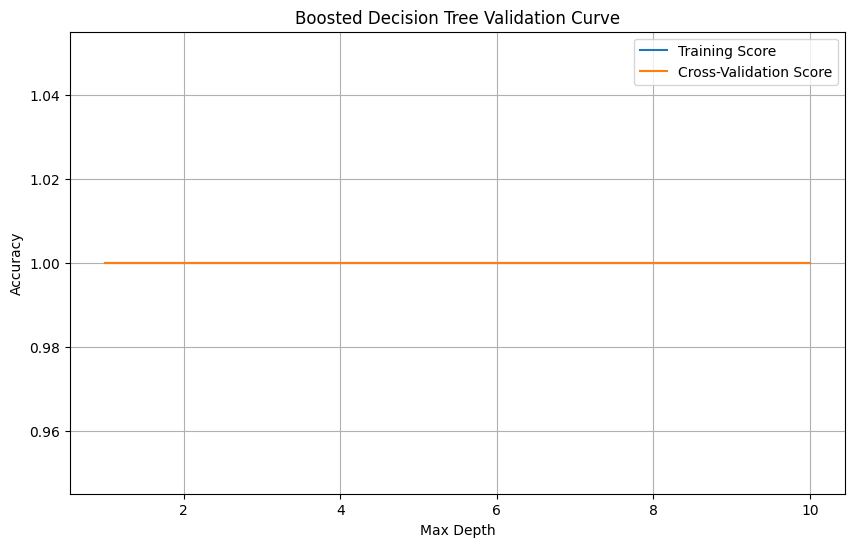

In [23]:
clf = XGBClassifier(objective='multi:softmax',enable_categorical=True,num_class=len(np.unique(y)))
clf.fit(X_train,y_train)
train_sizes, train_scores, test_scores = learning_curve(
    clf, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy', n_jobs=-1
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-Validation Score')
plt.title('Boosted Decision Tree Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Validation Curve
param_range = np.arange(1, 11)
train_scores, test_scores = validation_curve(
    clf, X, y, param_name="classifier__max_depth", param_range=param_range, cv=5, scoring="accuracy", n_jobs=-1
)

plt.figure(figsize=(10, 6))
plt.plot(param_range, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(param_range, np.mean(test_scores, axis=1), label='Cross-Validation Score')
plt.title('Boosted Decision Tree Validation Curve')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


--------------------------------------------------------------------------------

MODEL: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=6,
              num_parallel_tree=None, ...)

[*] Train Score: 1.0
[*] Test Score: 1.0

[*] Test Classification Report: 
               precision    recall  f1-score   support

           0       1.00     

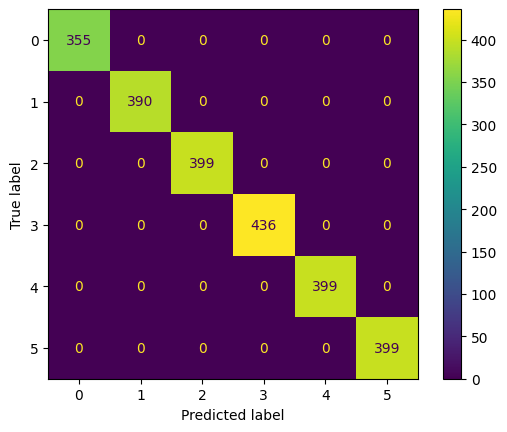

[*] Test Accuracy: 100.0%
--------------------------------------------------------------------------------

CPU times: total: 3.8 s
Wall time: 420 ms


In [24]:
%%time

y=le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=13)


clf = XGBClassifier(objective='multi:softmax',enable_categorical=True,num_class=len(set(y)))
clf.fit(X_train,y_train)

get_accuracy(clf)

<Figure size 1000x600 with 0 Axes>

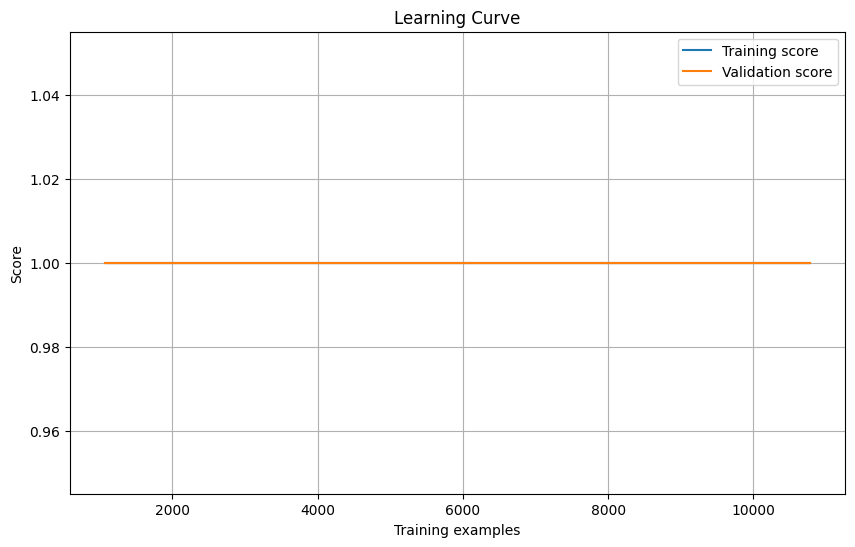

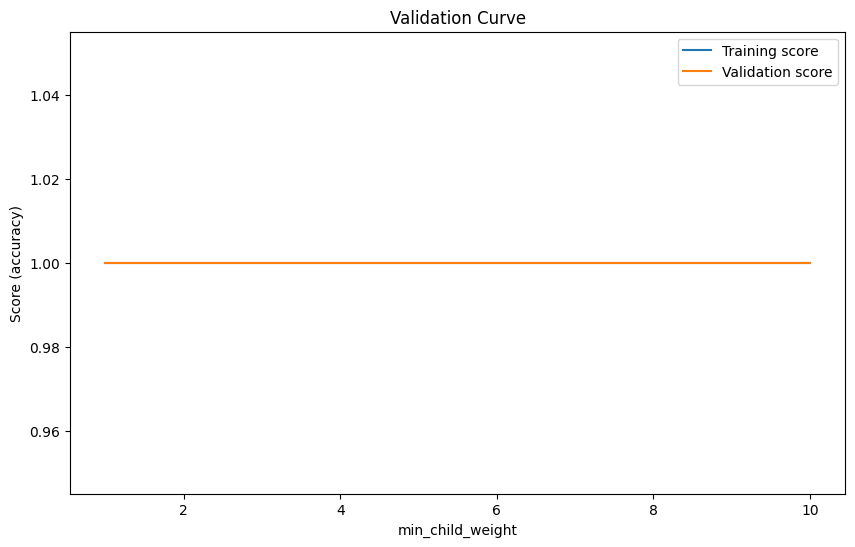

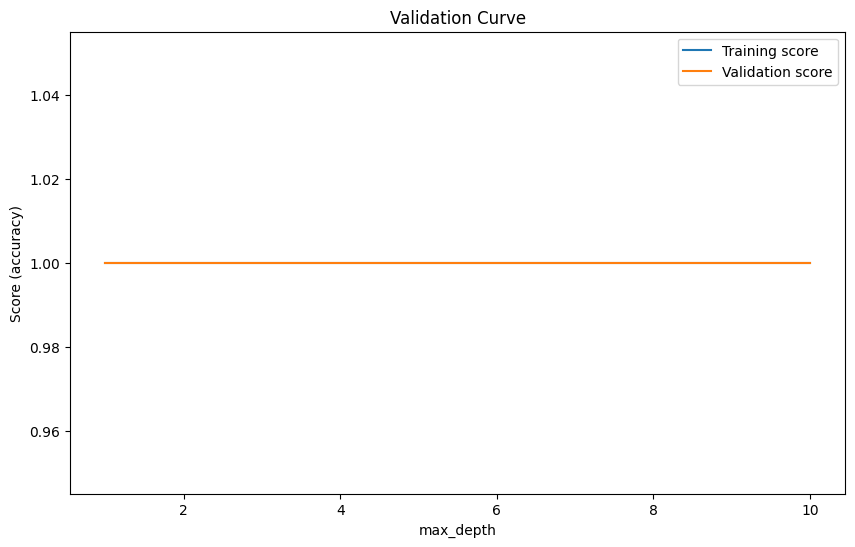

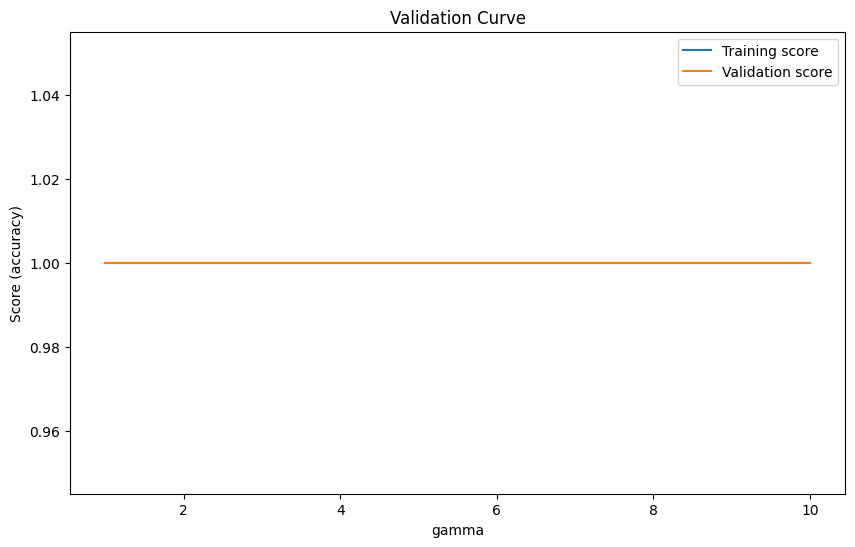

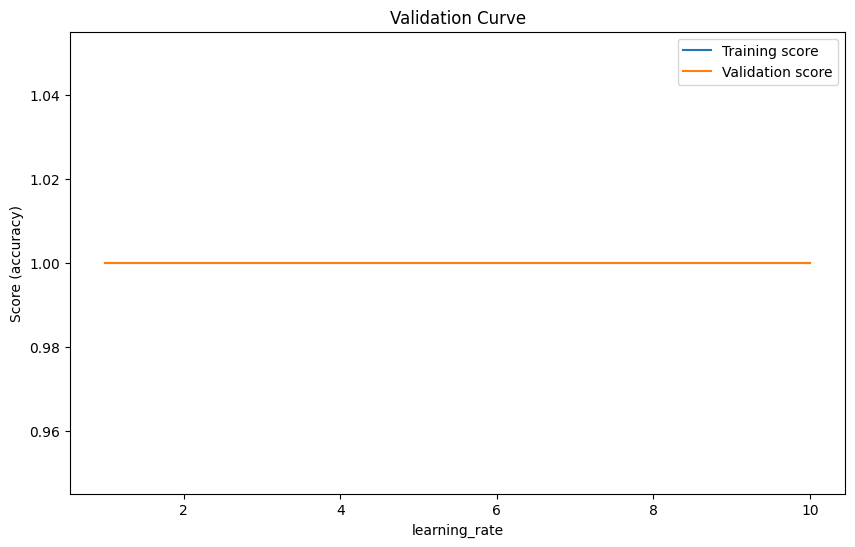

In [25]:
plt.figure(figsize=(10, 6))
plot_learning_curve(clf, "Learning Curve", X_train, y_train, cv=StratifiedKFold(n_splits=5))
plt.show()

# Plot the Validation curve

plot_validation_curve(clf,X_train, y_train,'min_child_weight',param_range=param_range, cv=5, scoring="accuracy")
plot_validation_curve(clf,X_train, y_train,'max_depth', cv=5, param_range=param_range, scoring="accuracy")
plot_validation_curve(clf,X_train, y_train,'gamma', cv=5, param_range=param_range, scoring="accuracy")
plot_validation_curve(clf,X_train, y_train,'learning_rate', cv=5, param_range=param_range, scoring="accuracy")

In [26]:
%%time

param_grid = {
    'max_depth': [3, 5],
    'min_child_weight': [1, 3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1],
    'learning_rate': [0.01, 0.1]
}

# Instantiate GridSearchCV
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best estimator from GridSearchCV
clf_gs = grid_search.best_estimator_

# Evaluate the model selected by GridSearchCV on the test set
y_pred_gs = clf_gs.predict(X_test)

# Decode the predictions if needed
# y_pred_decoded_gs = le.inverse_transform(y_pred_gs)

# Evaluate the model
accuracy_gs = accuracy_score(y_test, y_pred_gs)
f1_gs = f1_score(y_test, y_pred_gs, average='weighted')

print(f"GridSearchCV Model - Accuracy on Test Set: {accuracy_gs:.4f}")
print(f"GridSearchCV Model - F1 Score on Test Set: {f1_gs:.4f}")

# Additional details from GridSearchCV
print("GridSearchCV Best Parameters:")
print(grid_search.best_params_)


GridSearchCV Model - Accuracy on Test Set: 1.0000
GridSearchCV Model - F1 Score on Test Set: 1.0000
GridSearchCV Best Parameters:
{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.8}
CPU times: total: 10.3 s
Wall time: 50.8 s
